In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import (mean_absolute_percentage_error,
                             mean_squared_error, r2_score)


import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold



### 1. Run the feature engineering file to get the train, val, test set

[*********************100%***********************]  1 of 1 completed


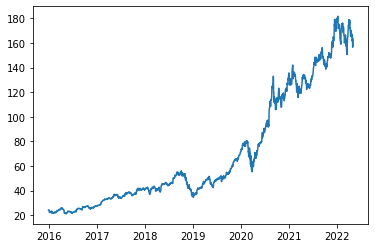

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573 entries, 0 to 1572
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1573 non-null   datetime64[ns]
 1   D_m3       1573 non-null   float64       
 2   D_m2       1573 non-null   float64       
 3   D_m1       1573 non-null   float64       
 4   Adj Close  1573 non-null   float64       
 5   bb_m1      1573 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 73.9 KB
           Date
0    2016-02-02
1    2016-02-03
2    2016-02-04
3    2016-02-05
4    2016-02-08
...         ...
1567 2022-04-22
1568 2022-04-25
1569 2022-04-26
1570 2022-04-27
1571 2022-04-28

[1572 rows x 1 columns]
         bb_m1      D_m3      D_m2      D_m1
0    -0.105413  0.007172  0.034541 -0.009349
1    -0.134902  0.034541 -0.009349 -0.020222
2    -0.108551 -0.009349 -0.020222  0.019793
3    -0.060615 -0.020222  0.019793  0.008035
4     0.042267  

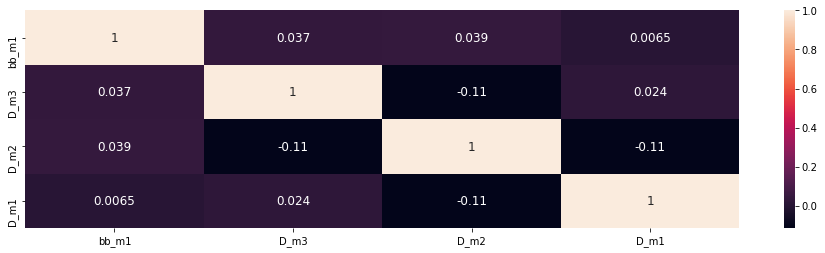

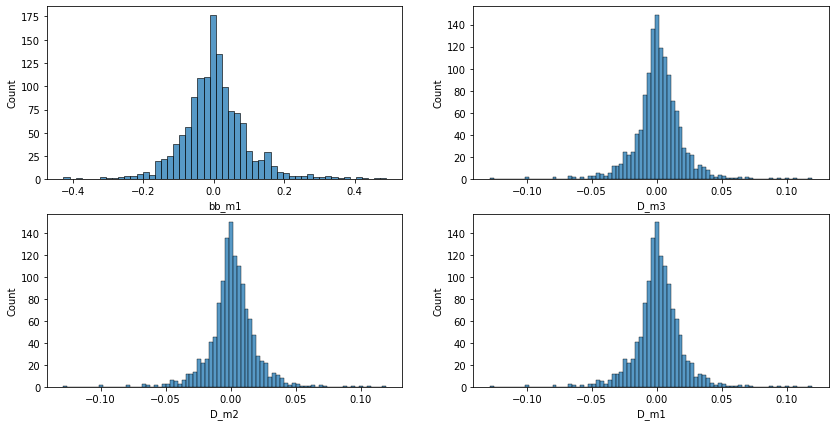

In [2]:
## Run below code to get data inclusive of Bband only with prices
%run DS105FP_ProjectScript_EdwinWan_1featureeng_final.ipynb

## Run below code to get data inclusive of MACD, MFI and BBand with prices
# %run DS105FP_ProjectScript_EdwinWan_1featureeng_initial.ipynb

### 2. Create the XGBoost model (base)

In [3]:
#Create the XGBoost model
model = xgb.sklearn.XGBRegressor()
model.fit(x_train , y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

### 3. Predict pct_change, calculate the predicted price to compare with actual. Performance is also tested

- Predict and calculate predicted price and performance for train set

In [6]:
train_predictions = model.predict(x_train)
train_predictions

array([-0.01551512,  0.01892538,  0.00710318, ..., -0.0010804 ,
        0.01346667, -0.01043244], dtype=float32)

In [7]:
pred_train = pd.DataFrame(train_predictions, columns=['pred_train'])
pred_train

,pred_train
0,-0.015515
1,0.018925
2,0.007103
3,-0.019560
4,0.005355
...,...
1331,-0.008750
1332,-0.007434
1333,-0.001080
1334,0.013467


In [8]:
df_compare = dates_train.merge(y_train, how='left', left_index=True, right_index=True)
df_compare = df_compare.merge(pred_train, how='left', left_index=True, right_index=True)
df_compare = df_compare.merge(prev_train, how='left', left_index=True, right_index=True)
df_compare['actual_close']=(df_compare['Adj Close']*df_compare['prev_close'])+df_compare['prev_close']
df_compare['pred_close']=(df_compare['pred_train']*df_compare['prev_close'])+df_compare['prev_close']
df_compare

,Date,Adj Close,pred_train,prev_close,actual_close,pred_close
0,2016-02-02,-0.020222,-0.015515,22.169815,21.721500,21.825848
1,2016-02-03,0.019793,0.018925,21.721500,22.151428,22.132588
2,2016-02-04,0.008035,0.007103,22.151428,22.329412,22.308774
3,2016-02-05,-0.026708,-0.019560,22.329412,21.733040,21.892639
4,2016-02-08,0.010529,0.005355,21.733040,21.961876,21.849418
...,...,...,...,...,...,...
1331,2021-05-17,-0.009258,-0.008750,126.912170,125.737160,125.801720
1332,2021-05-18,-0.011246,-0.007434,125.737160,124.323151,124.802435
1333,2021-05-19,-0.001282,-0.001080,124.323151,124.163826,124.188832
1334,2021-05-20,0.021012,0.013467,124.163826,126.772766,125.835899


In [9]:
rmse = np.sqrt(np.mean(df_compare['pred_close'] - df_compare['actual_close'])**2)
mape = mean_absolute_percentage_error(df_compare['actual_close'],df_compare['pred_close'])
r2 = r2_score(df_compare['actual_close'],df_compare['pred_close'])

print(f"The RMSE for train set is: {rmse}")
print(f"The MAPE for train set is: {mape}")
print(f"The R2 Score for test set is: {r2}")


The RMSE for train set is: 0.004297094274154523
The MAPE for train set is: 0.0029652128017791744
The R2 Score for test set is: 0.9999233083068876


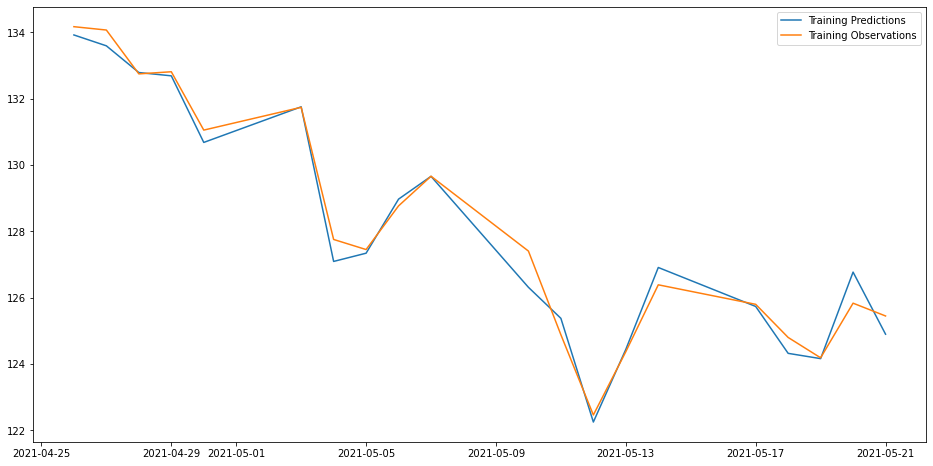

In [10]:
plt.figure(figsize=(16,8))
plt.plot(df_compare['Date'].tail(20), df_compare['actual_close'].tail(20))
plt.plot(df_compare['Date'].tail(20), df_compare['pred_close'].tail(20))
plt.legend(['Training Predictions', 'Training Observations'])



- Predict and calculate predicted price and performance for val set

In [11]:
val_predictions = model.predict(x_val)
pred_val = pd.DataFrame(val_predictions, columns=['pred_val'])


In [12]:
df_compare2 = dates_val.reset_index(drop=True).merge(y_val.reset_index(drop=True), how='left', left_index=True, right_index=True)
df_compare2 = df_compare2.merge(pred_val, how='left', left_index=True, right_index=True)
df_compare2 = df_compare2.merge(prev_val.reset_index(drop=True), how='left', left_index=True, right_index=True)
df_compare2['actual_close']=(df_compare2['Adj Close']*df_compare2['prev_close'])+df_compare2['prev_close']
df_compare2['pred_close']=(df_compare2['pred_val']*df_compare2['prev_close'])+df_compare2['prev_close']
df_compare2

,Date,Adj Close,pred_val,prev_close,actual_close,pred_close
0,2021-05-24,0.013314,-0.005399,124.900703,126.563652,124.226368
1,2021-05-25,-0.001574,-0.004962,126.563652,126.364502,125.935689
2,2021-05-26,-0.000394,-0.005802,126.364502,126.314705,125.631341
3,2021-05-27,-0.012377,-0.003004,126.314705,124.751328,125.935318
4,2021-05-28,-0.005348,0.007736,124.751328,124.084167,125.716356
...,...,...,...,...,...,...
105,2021-10-21,0.001474,-0.000092,148.852829,149.072220,148.839144
106,2021-10-22,-0.005285,0.000731,149.072220,148.284393,149.181155
107,2021-10-25,-0.000336,0.003997,148.284393,148.234528,148.877105
108,2021-10-26,0.004575,-0.001217,148.234528,148.912674,148.054098


In [13]:
rmse = np.sqrt(np.mean(df_compare2['pred_close'] - df_compare2['actual_close'])**2)
mape = mean_absolute_percentage_error(df_compare2['actual_close'],df_compare2['pred_close'])
r2 = r2_score(df_compare2['actual_close'],df_compare2['pred_close'])

print(f"The RMSE for validation set is: {rmse}")
print(f"The MAPE for validation set is: {mape}")
print(f"The R2 Score for test set is: {r2}")

The RMSE for validation set is: 0.0036653019168666518
The MAPE for validation set is: 0.01186770436115077
The R2 Score for test set is: 0.9372263803987276


- Predict and calculate predicted price and performance for test set

In [14]:
test_predictions = model.predict(x_test)
pred_test = pd.DataFrame(test_predictions, columns=['pred_test'])

In [15]:
df_compare3 = dates_test.reset_index(drop=True).merge(y_test.reset_index(drop=True), how='left', left_index=True, right_index=True)
df_compare3 = df_compare3.merge(pred_test, how='left', left_index=True, right_index=True)
df_compare3 = df_compare3.merge(prev_test.reset_index(drop=True), how='left', left_index=True, right_index=True)
df_compare3['actual_close']=(df_compare3['Adj Close']*df_compare3['prev_close'])+df_compare3['prev_close']
df_compare3['pred_close']=(df_compare3['pred_test']*df_compare3['prev_close'])+df_compare3['prev_close']
df_compare3

,Date,Adj Close,pred_test,prev_close,actual_close,pred_close
0,2021-10-28,0.024992,-0.001223,148.443954,152.153809,148.262344
1,2021-10-29,-0.018156,0.011880,152.153809,149.391357,153.961336
2,2021-11-01,-0.005607,-0.012359,149.391357,148.553650,147.545070
3,2021-11-02,0.007116,0.018435,148.553650,149.610764,151.292265
4,2021-11-03,0.009799,0.011193,149.610764,151.076767,151.285383
...,...,...,...,...,...,...
121,2022-04-22,-0.027821,-0.000021,166.419998,161.789993,166.416482
122,2022-04-25,0.006737,0.001521,161.789993,162.880005,162.036098
123,2022-04-26,-0.037328,-0.008151,162.880005,156.800003,161.552387
124,2022-04-27,-0.001467,-0.006528,156.800003,156.570007,155.776454


In [16]:
rmse = np.sqrt(np.mean(df_compare3['pred_close'] - df_compare3['actual_close'])**2)
mape = mean_absolute_percentage_error(df_compare3['actual_close'],df_compare3['pred_close'])
r2 = r2_score(df_compare3['actual_close'],df_compare3['pred_close'])

print(f"The RMSE for test set is: {rmse}")
print(f"The MAPE for test set is: {mape}")
print(f"The R2 Score for test set is: {r2}")

The RMSE for test set is: 0.07854323226075914
The MAPE for test set is: 0.015958710319452
The R2 Score for test set is: 0.8580421129288855


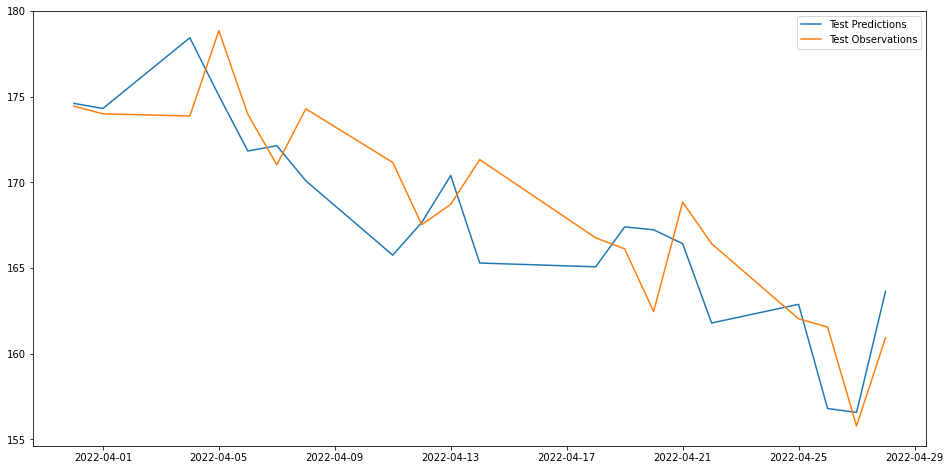

In [18]:
plt.figure(figsize=(16,8))
plt.plot(df_compare3['Date'].tail(20), df_compare3['actual_close'].tail(20))
plt.plot(df_compare3['Date'].tail(20), df_compare3['pred_close'].tail(20))
plt.legend(['Test Predictions', 'Test Observations'])

### 4. Check for feature importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

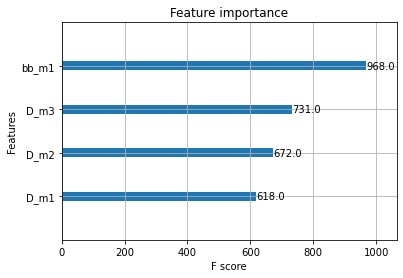

In [19]:
xgb.plot_importance(model)